# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [2]:
# Add your imports here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
from datetime import datetime, date, time
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [4]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'
FILE_EXTENSION = '.csv.zip'
colors = pd.read_csv(LEGO_DATA_FOLDER + '/colors' + FILE_EXTENSION)
inventories = pd.read_csv(LEGO_DATA_FOLDER + '/inventories' + FILE_EXTENSION)
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_parts' + FILE_EXTENSION)
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_sets' + FILE_EXTENSION)
part_categories = pd.read_csv(LEGO_DATA_FOLDER + '/part_categories' + FILE_EXTENSION)
parts = pd.read_csv(LEGO_DATA_FOLDER + '/parts' + FILE_EXTENSION)
sets = pd.read_csv(LEGO_DATA_FOLDER + '/sets' + FILE_EXTENSION)
themes = pd.read_csv(LEGO_DATA_FOLDER + '/themes' + FILE_EXTENSION)

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

In [5]:
# sets: year
from datetime import datetime, date, time


years_cp = sets['year'].copy()

years_cp[years_cp.str.startswith('-')] = years_cp[years_cp.str.startswith('-')].str.slice(start=1)
years_cp[years_cp.str.len()>4] = years_cp[years_cp.str.len()>4].str.slice(stop=4, step=None)
sets.year = years_cp

#convert to datetime, replacing decades (like '70s') by NaT and keep only the year part
sets.year = sets.year.apply(lambda x: pd.to_datetime(x, format=('%Y'), errors='coerce').year)
print("Time range of the sets is : [" + str(int(sets.year.min())) + ";" + str(int(sets.year.max())) + "]")

Time range of the sets is : [1950;2017]


In [6]:
# inventory_parts: quantity

#replace -inf and inf by NaN and drop NaNs from the dataset
inventory_parts.quantity.replace([np.inf, -np.inf], np.nan, inplace=True)
print("The average quantity of the invetory part is:", inventory_parts.quantity.mean())

The average quantity of the invetory part is: 3.836938260983857


A good start to check the data is to apply the method describe() on the different columns. In the year column of Sets DataFrame, 3 different inconsistencies have been observed:

1.) Some years were in form of decades (ex: 70s, 80s). This causes a problem because for instance if one wants to find the time range, "80s" would be the maximum of this range while years more than 2010 exist in the data.

2.) Some years had 5 digits (19955). One should notice that the last two digits are duplicated.

3.) Some years had a minus sign (-2013).

To clean up the data, we decided to create a copy of the year column and rewrite properly the typing mistakes. Then, we decided to replace the decade given by NaT because choosing an arbitrary year within the decade would distort future results. We also suppressed the last number in 5-digits numbers, as it was also due to a repetition of the fourth number.

In the quantity column of Inventory Parts DataFrame, 1 inconsistency has been observed: It's obvious that there can be no negative value for a quantity so every -inf value has been replaced by NaN. we can't replace it by 0 because it would again distort futur values.

### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [7]:
#1
car_sets = sets.set_index('name').filter(regex='Car$', axis=0)
cars_sets = sets.set_index('name').filter(regex='Cars$', axis=0)
car_sets_ids = pd.merge(car_sets, cars_sets, how='outer').id
inventories_ids = list(inventory_sets[inventory_sets.set_id.isin(car_sets_ids)].inventory_id.drop_duplicates().values)
print('Ids of inventories belonging to sets that contain cars : ', inventories_ids)

print('\nPercentage of inventories belonging to sets that contain cars : %s %%'%round(len(inventories_ids)/inventories.size*100,3))

print('Sets whose compound name comprises \'Car\' : ', list(sets.set_index('name').filter(regex='-Car$', axis=0).index))

Ids of inventories belonging to sets that contain cars :  [528, 908, 1371, 1401, 1418, 1649, 1716, 1732, 2917, 3109, 3764, 4051, 4187, 4430, 4969, 5358, 5857, 5904, 6086, 6530, 7151, 7363, 7430, 7881, 8140, 9426, 10406, 10515, 11861, 11966, 13355, 13380, 13398, 13427, 13696, 13941, 14011, 14174, 14493, 14711, 14919, 15010, 15694, 16131]

Percentage of inventories belonging to sets that contain cars : 0.188 %
Sets whose compound name comprises 'Car' :  ['ERBIE the Robo-Car', 'Jet-Car']


In order to fetch the list of inventories belonging to sets that contain cars, the sets names were sorted in order to keep only the ones containing the strict sequence of letters 'Car' or 'Cars' at the end. This query should not lead to false positive, due to this strict '$' condition; however we may miss some of the sets whose name need external conceptual knowledge to be associated to cars. Note that the plural condition 'Cars' is not necessary here because only one inventory (id=11966) is linked to these sets and it is also comprised in another car set.

Note that one could wonder whether we should pick compound names ending by '-Car' or not (regex='Car\$' or regex=' Car\$'), but these names correspond indeed to car lego sets.

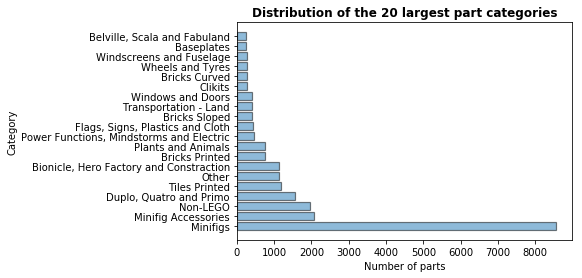

In [11]:
#2
category_counts = pd.Series(parts['part_cat_id']).value_counts().sort_values(ascending=False)
categories_indexed = part_categories.set_index(['id'])
category_names = categories_indexed.loc[category_counts.index]['name']

y_pos = np.arange(len(category_counts.index[:20]))
plt.barh(y_pos, category_counts.values[:20], align='center', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.yticks(y_pos, category_names[:20])
plt.xlabel('Number of parts')
plt.ylabel('Category')
plt.title('Distribution of the 20 largest part categories', fontweight="bold")
plt.show()

The whole 'parts' dataset has been sorted by its 'part_cat_id' field then value counts were computed and only the twenty more represented categories were plotted on a horizontal histogram, associated to their number of appearance. The main conclusion on this graph is that by far, most of the Lego parts are mini figurines.

In [9]:
#3
dominant_colors_df = pd.DataFrame()

#group inventory_sets by their set_ids
inventory_sets_grouped = inventory_sets.groupby('set_id')

#iterate over each set_id and its associated inventories to compute the dominant color
for set_id, group in inventory_sets_grouped:
    
    #fetch all inventory_parts belonging to this set and associate them to the quantity of similar inventories
    all_parts = inventory_parts[inventory_parts.inventory_id.isin(group.inventory_id)]
    all_parts['inventory_quantity'] = group['quantity']
    
    #get rid of -inf values, for future computation
    all_parts['quantity'].replace([-np.inf], np.nan, inplace=True)
    all_parts['quantity'].dropna(inplace=True)
    all_parts['inventory_quantity'].replace([-np.inf], np.nan, inplace=True)
    all_parts['inventory_quantity'].dropna(inplace=True)
    
    #multiply both quantities (inventory level and set level)
    all_parts['quantity'] = all_parts['quantity']*all_parts['inventory_quantity']
    
    #sort parts by their color and sum in order to have the total color counts over the whole set
    color_counts = all_parts.groupby('color_id')['quantity'].sum()
    
    if not color_counts.empty:
        #get the id of the color of the highest number of parts in the set
        dominant_color_id = color_counts.idxmax()
        
        #add a new row in dominant_colors_df
        temp_df = pd.DataFrame({'set_id':[set_id], 'color_id':[dominant_color_id]})
        dominant_colors_df = dominant_colors_df.append(temp_df)
    
#associate each set to its name, dominant color name and rgb value
sets_indexed = sets.set_index(['id'])
dominant_colors_df['set_name'] = [sets_indexed.loc[set_id]['name'] for set_id in dominant_colors_df['set_id']]
colors_indexed = colors.set_index(['id'])
dominant_colors_df['color_name'] = [colors_indexed.loc[color_id]['name'] for color_id in dominant_colors_df['color_id']]
dominant_colors_df['rgb_value'] = [colors_indexed.loc[color_id]['rgb'] for color_id in dominant_colors_df['color_id']]


#group by color type over all sets and return value_counts
dominant_colors_name_grouped = dominant_colors_df.groupby(dominant_colors_df['color_name'])
dominant_colors_counts = dominant_colors_name_grouped.size()

#plot on a horizontal bar chart and associate each bar to its corresponding color
dominant_colors_rgb = ['#'+group['rgb_value'].values[0] for name, group in dominant_colors_name_grouped]

#Print the dominant_color associated to each set
dominant_colors_df[['set_name', 'color_name']].head(30)

,set_name,color_name
0,NHL Action Set with Stickers,Black
0,Holiday Train,Black
0,Emerald Night,[No Color]
0,Horizon Express,[No Color]
0,{Town Vehicles},Black
0,Dacta Buildings,Black
0,DK Star Wars Brickmaster: Battle For The Stole...,[No Color]
0,Vakama (bagged),Red
0,Adventurers Car & Skeleton,Royal Blue
0,Adventurers Tomb,Royal Blue


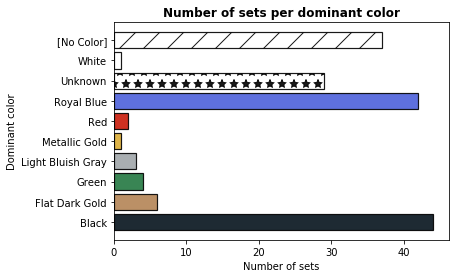

In [10]:
#plot on a horizontal bar chart
color_copy = dominant_colors_rgb.copy()

color_copy[7] = '#FFFFFF'
color_copy[9] = '#FFFFFF'

patterns = [ "", "" , "" , "" , "" , "", "", "*", "", "/" ]
y_pos = np.arange(len(dominant_colors_counts.index))
bar = plt.barh(y_pos, dominant_colors_counts.values, align='center', alpha=0.9, color=color_copy, edgecolor='black', linewidth=1.2)
plt.yticks(y_pos, dominant_colors_counts.index)

plt.xlabel('Number of sets')
plt.ylabel('Dominant color')
plt.title('Number of sets per dominant color', fontweight="bold") 

for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(patterns[i])
plt.show()

The strategy we used in this question, was to collect for each set, the complete list of its corresponding parts. Then, by coupling both the quantity of each inventory in each set, and the quantity of each part in each inventory, we were able to compute the dominant color of each set - that is the color possessed by the maximal number of parts in the set. Then a new dataframe (dominant_colors_df) was built. It contains for each set: its dominant color id, name and rgb value. This dataframe will be used in the next query.

Finally, value counts for each color over all sets were computed, and a horizontal bar chart was plotted. The rgb values were used to associate each horizontal bar to its corresponding color, enabling a more intuituve analysis of the result. The result shows us that the two main dominant colors represented are "black" and "royal blue", in their non transparent variants. We also find some other basic colors like "green" or "red", and more original ones like "metallic gold", "light bluish gray" or "flat dark gold". Moreover, we notice that the number of total dominant colors is very small, meaning that most parts have similar colors and also that no set has a transparent dominant color. The two categories "Unknown" and "No color" are abundantly represented. This can be explained by the fact that the data have probably been filled by hand, and hence are not really accurate.

Note that for our analysis, we did not have to take into account the "is_trans" field of color items because this specificity results also in a different color name and a different rgb value.



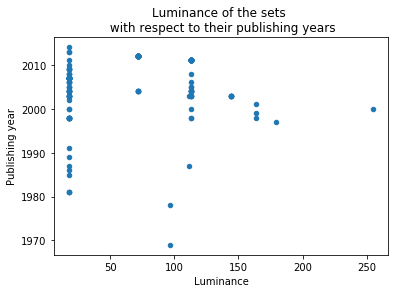

In [10]:
#4
#Reuse result from previous question : dominant_colors_df contains columns 'set_name', 'dominant_color_name' and 'rgb_value'

#add a column containing publishing years
sets_indexed_by_name = sets.drop_duplicates(['name']) #to get rid of the problem of multiple corresponding sets
sets_indexed_by_name = sets_indexed_by_name.set_index(['name'])
publishing_years = [sets_indexed_by_name.loc[set_name].year for set_name in dominant_colors_df['set_name']]
dominant_colors_df['year']=publishing_years

#convert hex color code to rgb
dominant_colors_df['rgb_tuple'] = [tuple(int(value[i:i+2], 16) for i in (0, 2 ,4)) for value in dominant_colors_df['rgb_value']]

#compute luminance
dominant_colors_df['luminance']=[round(math.sqrt(0.299*(val[0])**2 + 0.587*(val[1])**2 + 0.114*(val[2])**2), 2) for val in dominant_colors_df['rgb_tuple']]


#scatter plot luminance vs. publishing year for each set
ax = dominant_colors_df.plot.scatter(x='luminance', y='year')
legend = ax.set(title='Luminance of the sets \n with respect to their publishing years', xlabel='Luminance', ylabel='Publishing year')

On this scatter plot, we can see that the luminance increases and get more diverse with the years. It can be easily explain by the improvement of the production technics which allow more color possibilities.

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [11]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [12]:
bikes_df = pd.read_json(BIKES_DATA_FOLDER + '/metro-bike-share-trip-data.json.zip')

### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

In [13]:
end_time = pd.to_datetime(bikes_df['End Time'])
start_time = pd.to_datetime(bikes_df['Start Time'])

range_df = pd.concat([bikes_df.dtypes, bikes_df.describe().loc['min'], bikes_df.describe().loc['max']], axis=1)
range_df = range_df.rename(columns = {0:'Type'})
range_df.at['End Time',['min', 'max']] = [min(end_time), max(end_time)]
range_df.at['Start Time',['min', 'max']] = [min(start_time), max(start_time)]
print('\n', 'Type and Value Range'.center(80, '*'))
print(range_df)
print('\n')

bikes_df['Bike ID'] = bikes_df['Bike ID'].astype('category') #763 categories
bikes_df['Ending Station ID'] = bikes_df['Ending Station ID'].astype('category') #67 categories
bikes_df['Starting Station ID'] = bikes_df['Starting Station ID'].astype('category') #67 categories
bikes_df['Passholder Type'] = bikes_df['Passholder Type'].astype('category') #4 categories
bikes_df['Plan Duration'] = bikes_df['Plan Duration'].astype('category') # 3 categories
bikes_df['Trip Route Category'] = bikes_df['Trip Route Category'].astype('category') #2 categories

redundant_columns = bikes_df[['Duration', 'Plan Duration']]

bikes_df.drop(['Duration', 'Plan Duration'], axis = 1,  inplace=True)

print('\n', 'Type and Shape of redundant columns (the dropped columns)'.center(80, '*'))
print(redundant_columns.dtypes)
print(redundant_columns.shape)
print('\n', 'Type and Shape after extracting the redundant columns'.center(80, '*'))
print(bikes_df.dtypes)
print(bikes_df.shape)

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.



 ******************************Type and Value Range******************************
                               Type                  min                  max
Bike ID                     float64                 1349                 6728
Duration                      int64                   60                86400
End Time                     object  2016-07-07 04:20:00  2017-04-02 10:32:00
Ending Station ID           float64                 3000                 4108
Ending Station Latitude     float64                    0              34.0643
Ending Station Longitude    float64             -118.473                    0
Passholder Type              object                  NaN                  NaN
Plan Duration               float64                    0                  365
Start Time                   object  2016-07-07 04:17:00  2017-03-31 23:45:00
Starting Station ID         float64                 3000                 4108
Starting Station Latitude   float64                    0   

__\* Briefly explain your approach here \*__

Bike ID, Ending Station ID, Starting Station ID, Passholder Type, Plan Duration, Trip Route Category are chosen as a Categorical attribute.

There are redundant columns in the dataset: 

1.)Duration column is a redundant column because it depends on the corresponding  difference of End Time and Start Time values.

2.) Plan durataion is a redundant column because it can be deduced if the passholder type is known.

Latitudes and longitudes could be also redundant columns if geographical positions were stored in a different DataFrame with respect to Station ID's.

Having redundant columns requires maintenance because whenever there is a change in the columns on which the redundant column depends, this column should be updated respectively to the changes. A second disadvantage is that more space will be needed for adding the redundant columns.

The initial format is more susceptible to inconsistencies because whenever there is an inconsistency in a given column, this can lead to major problems in the results depending on this column. If we consider duration column, maximum value is 86400 seconds for a trip who took more than 5 days(index 23475). If we base on the given duration column values, instead of calculating the difference between end and start time, we can end up with false answers.

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

Text(0,0.5,'Number of Stations')

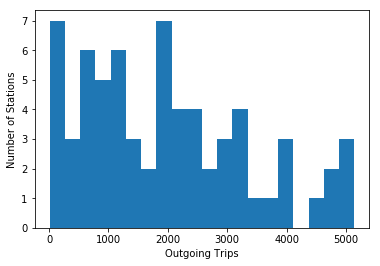

In [14]:
#1
plt.hist(bikes_df['Starting Station ID'].value_counts(), bins=20) 
plt.xlabel("Outgoing Trips")
plt.ylabel("Number of Stations")

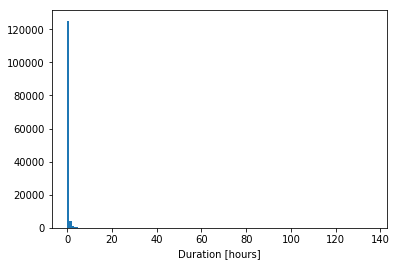

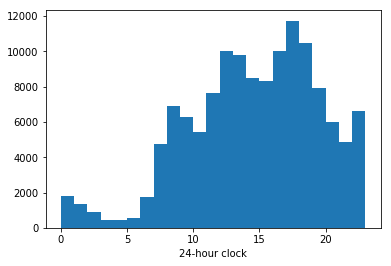

In [15]:
#2
duration = (end_time-start_time).astype('timedelta64[h]')
bins1 = (duration.max()-duration.min()).astype('int') 
plt.hist(duration, bins1)
plt.xlabel('Duration [hours]')
plt.show()

trip_starting_hour = start_time.dt.hour
bins2 = (trip_starting_hour.max() - trip_starting_hour.min()).astype('int') #There are 23 bins since a day is 24-hour
plt.hist(trip_starting_hour, bins2)
plt.xlabel('24-hour clock')
plt.show()


Regarding the first plot, which shows the time of trips (in hours) on x axis and number of trips on y axis, it's obviuos that most trips have lasted less than 5 hours. Espacially the number of trips under 1 hour is 125203 which corresponds approximately to 95% of the all trips in the dataset.

We think that there is one thing which deserves to be clearly explained regarding the first plot. In the given dataset, the values in duration column are capped at 24 hours (according to the website) but if one calculates the difference between the end and start time, there are values much bigger than 24 hours (136 hours at maximum). Thus, instead of using duration column in our plot, we used the trip lengths which are manually calculated.

On the other hand, the second plot summarizes the number of trips on a daily basis. Since most of the people is sleeping during the night, the number of trips is the least from midnight(00:00) until (06:00) comparing to the rest of the day. From 06:00, the number starts remarkably increases until 09:00 and hits a pick in the interval of (08:00-09:00) when people usually leave their home to start the work or school day. Around the noon is the second pick since people are having their launch break. The third pick and also the global maximum comes around 17:00-18:00 when people end their day and go back to their home. The fourth and the last pick is situated in the interval 22:00-23:00 which is the going-out and drinking hours for fun people :). In general, this plot sticks highly to the human daily behaviour. 

Passholder Type,Flex Pass,Monthly Pass,Staff Annual,Walk-up
Trip Route Category,,,,
One Way,0.075509,0.648033,0.002499,0.273959
Round Trip,0.037779,0.295033,0.006492,0.660696


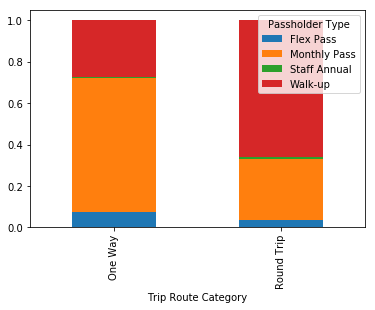

In [16]:
#3
trip_categories_grouped =  bikes_df.groupby('Trip Route Category')['Passholder Type'].value_counts().unstack(level=-1)
passholders = bikes_df['Passholder Type'].drop_duplicates()
trip_categories_grouped.loc[:,passholders] = trip_categories_grouped.loc[:,passholders].div(trip_categories_grouped.sum(axis=1), axis=0)
trip_categories_grouped.plot.bar(stacked = True)
trip_categories_grouped

__/ trip_categories_grouped.loc[:,passholders] = trip_categories_grouped.loc[:,passholders].div(trip_categories_grouped.sum(axis=1), axis=0) /__ command divides the rows of the "trip_categories_grouped" dataframe by the sum of the corresponding row. Thus, values in each row (each trip route category) sums up to 1.

Passholder Type,Flex Pass,Monthly Pass,Staff Annual,Walk-up
Trip Route Category,,,,
One Way,2653,24570,97,7510
Round Trip,126,1056,39,2129


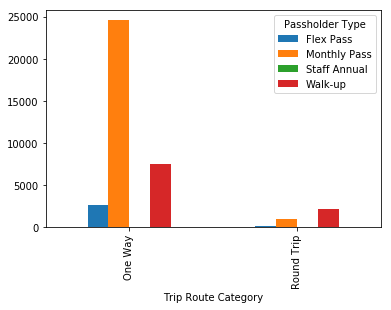

In [17]:
#4
morning_trips = bikes_df[trip_starting_hour < 12].groupby('Trip Route Category')['Passholder Type'].value_counts().unstack(level=-1)
morning_trips.plot.bar()
morning_trips

Considering the morning bike trips, there is one outlier for one way trips which is the staff annual passholder type. For round trips, we have flex pass passholder type as outlier in addition to the staff annual passholder type.

In [18]:
#5
first_interval_hours = []
trip_sum = 0
hour_list = trip_starting_hour.value_counts().index
total_trips = len(bikes_df)

for hour in hour_list:
    if trip_sum <= int(total_trips/2):
        trip_sum = trip_sum + trip_starting_hour.value_counts()[hour]
        first_interval_hours.append(hour)

       
second_interval_hours = list(set(hour_list).difference(set(first_interval_hours)))    
first_interval = bikes_df[trip_starting_hour.isin(first_interval_hours)]
second_interval = bikes_df[trip_starting_hour.isin(second_interval_hours)]

first_interval_grouped = first_interval.groupby('Trip Route Category')['Passholder Type'].value_counts().unstack(level=-1)
second_interval_grouped = second_interval.groupby('Trip Route Category')['Passholder Type'].value_counts().unstack(level=-1)
frames = [first_interval_grouped, second_interval_grouped]
df = pd.concat(frames, keys=['First Interval','Second Interval'], names=['Intervals'])
df.reset_index(level = ['Intervals','Trip Route Category'], inplace = True)
df.columns.name = 'index'
df

index,Intervals,Trip Route Category,Flex Pass,Monthly Pass,Staff Annual,Walk-up
0,First Interval,One Way,4582,39444,163,18025
1,First Interval,Round Trip,266,2001,35,4300
2,Second Interval,One Way,4452,38088,136,14752
3,Second Interval,Round Trip,217,1771,48,4147


The proportion of trips doesn't depend on the intervals since the values are very similar for each row and column.

The company wouldn't make a significant benefit by changing the paying scheme for monthly pass users because the number of trips in the first interval is 39444 and 38088 in the second interval for one way trips. For round trips, the trip numbers are 2001 and 1771 for respectively first and second interval.